# Importing the packages

In [1]:
# import numpy as np
import pandas as pd
import math
import string

# import pickle
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_web_sm

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer

from gensim.models import LdaModel
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

from wordcloud import WordCloud

from sklearn.model_selection import ParameterGrid

import re
from collections import Counter

# import dash
# from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Loading the dataset

In [2]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')
print(df.shape)
df.head(5)

(2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


# Preprocessing

At first, the text of each article is tokenized, and the preprocessing methods below is done to the text. 
1. Tokenize
2. Lowercase
3. Remove punctuations
4. Remove numbers
5. Remove stop words
6. Lemmatize
7. Remove pronouns
8. Remove short words

In the end, preprocessed text is stores in a new column of dataframe named 'preprocessed_content'.

In [3]:
# tokenizing
nlp = spacy.load("en_core_web_sm")

def tokenize_text(text):
  doc = nlp(text)
  tokens = [token.text for token in doc]
  return tokens

df['tokens'] = df['content'].apply(tokenize_text)

# lowercasing
df['tokens'] = df['tokens'].apply(lambda tokens: [token.lower() for token in tokens])

# reomving punctuatuins
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in string.punctuation])

# removing numbers
df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token.isalpha()])                                                                                                 

print(df.head())

   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                              tokens  
0  [quarterly, profits, at, us, media, giant, tim...  
1  [the, dollar, has, hit, its, highest, level, a...  
2  [the, owners, of, embattled, russian, oil, gia...  
3  [british, airways, has, blamed, high, fuel, pr...  
4  [shares, in, uk, drinks, and, 

In [4]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]

token_counts = Counter(all_tokens)

most_common_tokens = [token for token, count in token_counts.most_common(100)]

print(most_common_tokens)

['the', 'to', 'of', 'and', 'a', 'in', 'for', 'is', 'that', 'it', 'on', 'said', 'was', 'he', 'be', 'with', 'has', 'as', 'have', 'at', 'by', 'will', 'but', 'are', 'i', 'not', 'from', 'they', 'his', 'we', 'mr', 'this', 'an', 'would', 'had', 'which', 'been', 'their', 'more', 'year', 'its', 'up', 'were', 'also', 'who', 'people', 'new', 'one', 'there', 'us', 'about', 'can', 'after', 'out', 'or', 'than', 'all', 'could', 'if', 'you', 'm', 'over', 'do', 'last', 'first', 'when', 'time', 'two', 'world', 'government', 'other', 'so', 'now', 'some', 'what', 'into', 'she', 'uk', 'years', 'them', 'best', 'against', 'no', 'only', 'just', 'make', 'being', 'told', 'like', 'get', 'such', 'made', 'game', 'very', 'should', 'film', 'many', 'three', 'back', 'because']


In [5]:
# removing stop words
most_common_tokens.remove('film')
most_common_tokens.remove('game')
for word in most_common_tokens:
    STOP_WORDS.add(word)

df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if token not in STOP_WORDS])

# lemmatization
def lemmatizer(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

df["tokens"] = df["tokens"].apply(lemmatizer)

# removing pronouns
common_pronouns = {
    "i", "you", "he", "she", "it", "we", "they",
    "me", "him", "her", "us", "them", "myself",
    "yourself", "himself", "herself", "ourselves",
    "themselves"
}
df["tokens"] = df["tokens"].apply(lambda tokens: [token for token in tokens if token.lower() not in common_pronouns])

# removing shoert tokens
df['tokens'] = df['tokens'].apply(lambda tokens: [token for token in tokens if len(token) >= 3])

# converting tokens to string
df["processed_content"] = df["tokens"].apply(lambda tokens: " ".join(tokens))

df = df.drop(['tokens'], axis=1)
print(df.head())

   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                   processed_content  
0  quarterly profit medium giant timewarner jump ...  
1  dollar hit high level euro month federal reser...  
2  owner embattle russian oil giant yukos ask buy...  
3  british airways blame high fuel price drop pro...  
4  share drink food firm ally dom

# Feature Extraction from texts

Using TF-IDF vectorization, text features matrix is calculated.

TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic used in text mining and information retrieval to evaluate how important a word is in a document relative to a collection or corpus. The idea is to give higher weights to words that appear frequently in a document but rarely across all documents, making them more useful for distinguishing content.

- Term Frequency (TF): Measures how frequently a term appears in a document.
- Inverse Document Frequency (IDF): Downscales terms that appear in many documents, reducing the weight of common words.

In [6]:
tf_idf_vectorizer = TfidfVectorizer(max_features=8192)

feature_matrix = tf_idf_vectorizer.fit_transform(df['processed_content'])
feature_names = tf_idf_vectorizer.get_feature_names_out()
tf_idf_df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)

print(tf_idf_df.shape)
tf_idf_df.iloc[:5, :50]

(2225, 8192)


,aaa,aaas,aaron,abandon,abandonment,abba,abbas,abbasi,abbott,abc,...,accolade,accommodate,accommodation,accompany,accomplish,accord,according,account,accountability,accountable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071005,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142180,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0



TF-IDF calculation consists of two parts:

1. Term Frequency (TF):

    This is calculated using the formula $TF = \frac{\text{Frequency of term in doc}}{\text{Number of all terms in doc}}$. This part is essentially a simple count of how often a word appears in a document.

2. Inverse Document Frequency (IDF):

    This part evaluates the importance of a term across all documents. Words that appear in many documents are considered less important, while words that appear in fewer documents are considered more important. Therefore, we calculate this metric using the following formula:

$$IDF = \log(\frac{\text{Total number of documents}}{\text{Number of documents containing the term}})$$

Finally, by multiplying these two metrics, we create the TF-IDF metric, which weights each term based on its importance and its frequency in the document, allowing us to build more meaningful features.

For example, if we have two documents containing the terms "green, green, red" and "green, yellow, yellow," the frequency of the terms would be as follows:
- Document 1: (green = 2), (red = 1)
- Document 2: (green = 1), (yellow = 2)

However, when using TF-IDF, we get:
- Document 1: (green = 0.8), (red = 0.5)
- Document 2: (green = 0.4), (yellow = 0.8)

As you can see, even though the term "red" appears once in Document 1 and "green" appears once in Document 2, the TF-IDF value for "green" in Document 2 is lower. This is because the term "green" appears in both documents, making it less significant.

# Clustering

### Using PCA for dimensionality reduction

In [7]:
pca = PCA(n_components=0.95)

tf_idf_pca = pca.fit_transform(tf_idf_df)

print(tf_idf_pca.shape)
tf_idf_pca

(2225, 1530)


array([[-0.0122814 ,  0.14353893, -0.0001622 , ..., -0.00473701,
         0.01011374,  0.01019958],
       [ 0.06716137,  0.13083649, -0.06241999, ..., -0.00594344,
         0.01453091, -0.00809097],
       [ 0.02961443,  0.09055169, -0.01684088, ..., -0.00850647,
        -0.01039412,  0.00141869],
       ...,
       [ 0.04225313,  0.07384165,  0.00984921, ..., -0.00366152,
         0.01219699,  0.01580368],
       [-0.00019328,  0.06728007,  0.00286407, ...,  0.00905701,
         0.00640001, -0.00980578],
       [-0.1099494 , -0.06340644, -0.08595224, ..., -0.01257694,
        -0.01784072,  0.02706989]])

Most clustering algorithms, including K-Means, do not perform well with high-dimensional data, and dimensionality reduction can help address this issue because, in high-dimensional spaces, the distances between data vectors become closer, reducing the effectiveness of distance metrics like Euclidean distance, and the increased dimensions introduce more noise, causing clustering models to overfit and lose their performance.

### KMeans for Clustering

#### Finding the best number of clusters
Using Distortion standard and visualizing the results using elbow plot

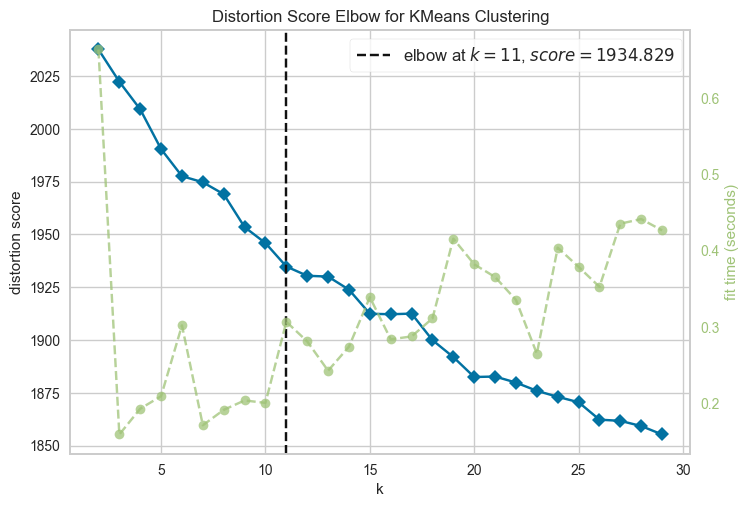

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
KElbowVisualizer(KMeans(), k=(2, 30)).fit(tf_idf_pca).show()

This part shows the best number of clusters for this dataset is 9.

#### Applying KMeans
Using KMeans function from sklearn library.

In [9]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

df['cluster'] = kmeans.fit_predict(tf_idf_pca)
print(df.head())

   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                   processed_content  cluster  
0  quarterly profit medium giant timewarner jump ...        8  
1  dollar hit high level euro month federal reser...        4  
2  owner embattle russian oil giant yukos ask buy...        2  
3  british airways blame high fuel price drop pro...

### Visualizing Clusters

First, t-SNE algorithm is used to reduce the dimensionality of features matrix to 2.

In [10]:
tsne = TSNE(n_components=2, random_state=42)
tf_idf_tsne = tsne.fit_transform(tf_idf_df)

print(tf_idf_tsne.shape)
tf_idf_tsne

(2225, 2)


array([[ 29.570824 ,  40.06979  ],
       [ 44.529747 ,  21.299267 ],
       [ 61.996017 ,  21.018116 ],
       ...,
       [  7.1354957,  33.868908 ],
       [ -7.5339017,  47.01447  ],
       [-11.081727 ,   4.909823 ]], dtype=float32)

Then using matplotlib library, the results of clustering is visualized in the 2d space.

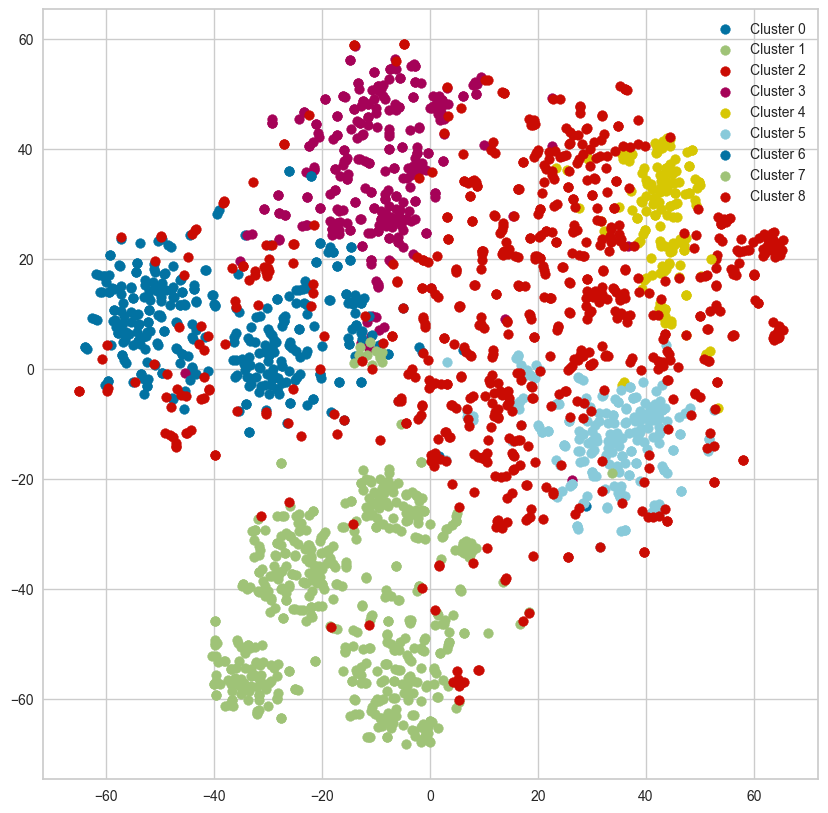

In [11]:
plt.figure(figsize=(10, 10))
for i in range(optimal_k):
    plt.scatter(tf_idf_tsne[df['cluster'] == i, 0], tf_idf_tsne[df['cluster'] == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

The t-SNE algorithm begins by calculating the similarity between each pair of data points in the high-dimensional space, aiming to determine the probability that one data point will select another as its neighbor. This probability is calculated using a normal distribution. Then, by computing the conditional probability of each pair of points relative to one another, it symmetrizes the similarity probabilities for all pairs of points.

Once these similarities are determined, the algorithm attempts to map the data into a lower-dimensional space (2D or 3D) without causing significant harm to the data. In this step, using relative entropy (Kullback–Leibler (KL) divergence), which is a measure of how one probability distribution diverges from another, the algorithm tries to minimize this divergence.

In this phase, the optimization process is performed iteratively using gradient descent. The goal is to minimize the distance between similar points and maximize the distance between dissimilar points in the new low-dimensional space. The algorithm iteratively adjusts the positions of the points using the gradients of the KL divergence with respect to their positions. Once these distances are optimized, the algorithm completes its task.

# Topic Modeling

### Choosing an algorithm
###### LDA Algorithm

This algorithm makes two assumptions about documents and topics:  
1. Each document is a mixture of topics.  
2. Each topic is a collection of words with a specific probability distribution.

- Each document has a Dirichlet Distribution of topics.  
- Each topic has a Dirichlet Distribution of words.  
- The algorithm seeks to find these distributions of topics and words using the documents.

Initially, the algorithm randomly assigns topics to the words in the documents. Then, based on the topics present in each document and the collection of words in each topic, the algorithm reassigns topics to each word. This process is repeated multiple times until a satisfactory result is achieved. The output of this algorithm is the Dirichlet distribution of documents based on topics and the Dirichlet distribution of topics based on words. In other words, the output specifies the percentage distribution of topics for each document and the percentage distribution of words assigned to each topic.


###### NMF Algorithm

This algorithm constructs a matrix where the rows represent documents, the columns represent words, and each entry indicates how much a word is related to a document.

The algorithm decomposes this matrix into two smaller matrices:  
1. A Weight Matrix: This matrix provides the weight of each topic with respect to a document.  
2. A Dictionary Matrix: This matrix provides the collection of words in each topic.

By multiplying these two matrices, the original matrix is approximately reconstructed. That is, each document (a row in the original matrix) is the result of multiplying the row of topic weights (from the Weight Matrix) by the Dictionary Matrix. In other words, it is the product of the topic weights for the document and the topics themselves.

The calculation process works as follows: Given the original matrix, the algorithm seeks to decompose it into the two matrices described above, such that their product has the least difference from the original matrix, providing a good approximation. Initially, the two matrices are created randomly, and then they are iteratively refined until a good approximation is achieved.


We have chosen the Latent Dirichlet Allocation (LDA) algorithm.

### Making Dictionary and Corpus for each cluster
Used gensim library's finctions and classes.

In [12]:
cluster_groups = df.groupby('cluster')['processed_content'].apply(lambda x: [doc.split() for doc in x])
cluster_dictionaries = {cluster: Dictionary(documents) for cluster, documents in cluster_groups.items()}

cluster_dictionaries = {
    cluster: Dictionary(documents) for cluster, documents in cluster_groups.items()
}

cluster_corpora = {
    cluster: [cluster_dictionaries[cluster].doc2bow(doc) for doc in documents]
    for cluster, documents in cluster_groups.items()
}

### Finding the optimal number of topics for each cluster
With $C_V$, a coherence measurement, the best number of topics for each cluster is found.

In [13]:
topic_counts = [5, 10, 15, 20, 25]

best_lda_models = {}
best_coherence_scores = {}

for cluster_num, documents in cluster_groups.items():
    print(f"Processing Cluster {cluster_num}")

    dictionary = cluster_dictionaries[cluster_num]
    corpus = cluster_corpora[cluster_num]

    best_model = None
    highest_score = -1

    for num_topics in topic_counts:
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=documents,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()

        print(f"Cluster {cluster_num}, Topics: {num_topics}, Coherence: {coherence_score}")

        if coherence_score > highest_score:
            best_model = lda_model
            highest_score = coherence_score

    best_lda_models[cluster_num] = best_model
    best_coherence_scores[cluster_num] = highest_score
    print(f"Best Model for Cluster {cluster_num}: {highest_score}")

print("Best Coherence Scores for Each Cluster:")
for cluster_num, score in best_coherence_scores.items():
    print(f"Cluster {cluster_num}: {score}")

Processing Cluster 0
Cluster 0, Topics: 5, Coherence: 0.3472321130360781
Cluster 0, Topics: 10, Coherence: 0.3311916022944716
Cluster 0, Topics: 15, Coherence: 0.3443513733762672
Cluster 0, Topics: 20, Coherence: 0.3429580529510857
Cluster 0, Topics: 25, Coherence: 0.37475044912567584
Best Model for Cluster 0: 0.37475044912567584
Processing Cluster 1
Cluster 1, Topics: 5, Coherence: 0.43927362251438706
Cluster 1, Topics: 10, Coherence: 0.4349941404398666
Cluster 1, Topics: 15, Coherence: 0.4669605272110125
Cluster 1, Topics: 20, Coherence: 0.5052664113081123
Cluster 1, Topics: 25, Coherence: 0.4488022893263625
Best Model for Cluster 1: 0.5052664113081123
Processing Cluster 2
Cluster 2, Topics: 5, Coherence: 0.3798494134949092
Cluster 2, Topics: 10, Coherence: 0.3960989139953076
Cluster 2, Topics: 15, Coherence: 0.4247419415525802
Cluster 2, Topics: 20, Coherence: 0.47096691633187027
Cluster 2, Topics: 25, Coherence: 0.4415504321194315
Best Model for Cluster 2: 0.47096691633187027
Proce

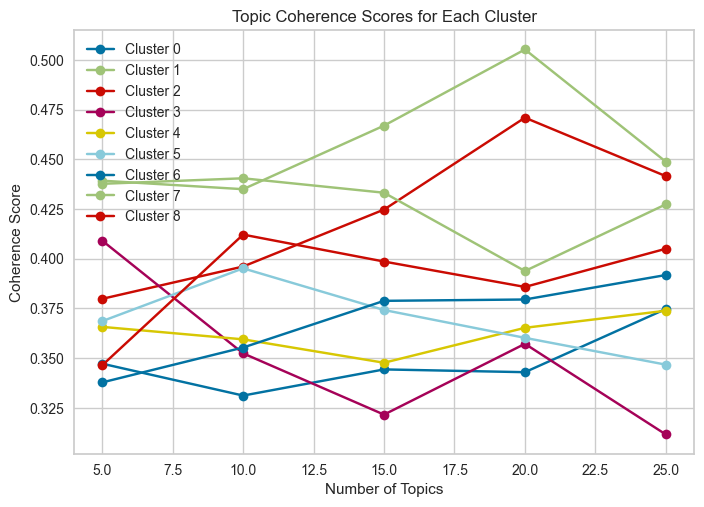

In [14]:
for cluster_num, documents in cluster_groups.items():
    scores = []
    for num_topics in topic_counts:
        lda_model = LdaModel(
            corpus=cluster_corpora[cluster_num],
            id2word=cluster_dictionaries[cluster_num],
            num_topics=num_topics,
            random_state=42,
            passes=10
        )
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=documents,
            dictionary=cluster_dictionaries[cluster_num],
            coherence='c_v'
        )
        scores.append(coherence_model.get_coherence())

    plt.plot(topic_counts, scores, marker='o', label=f'Cluster {cluster_num}')

plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores for Each Cluster')
plt.legend()
plt.grid(True)
plt.show()

This metric is used to evaluate the quality of topics generated by models such as LDA. In this method, a set of keywords is first selected for each topic. Then, by converting these words into numerical vectors, we begin calculating similarity. In this step, using similarity measures such as cosine similarity, we measure the degree of similarity between the words in each topic. We then evaluate the quality of the topic based on the similarity of its words.

Finally, by examining the correlation of similarity between the words in a topic, we take the average of these correlation scores to determine the overall quality of the model.

# Extraction keywords for each document

For each data of dataframe, the 3 best topics which the model has predicted for it are extracted. Then the 2 most important keywords of each topic are extracted.

In [15]:
top_keywords_list = []

for i, row in df.iterrows():
    cluster_num = row["cluster"]
    tokens = row["processed_content"].split()

    dictionary = cluster_dictionaries[cluster_num]
    doc_bow = dictionary.doc2bow(tokens)

    doc_topics = best_lda_models[cluster_num].get_document_topics(doc_bow)

    top_three_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)[:3]

    keywords_for_doc = []

    for topic_id, _ in top_three_topics:
        top_terms = best_lda_models[cluster_num].show_topic(topic_id, topn=2)
        keywords_for_doc.extend(term for term, _ in top_terms)

    top_keywords_list.append(keywords_for_doc)

df["top_keywords"] = top_keywords_list

# Word Clouds

First, the number of repetitions of words of each cluster is found. (for the top ten keywords of each topic.) Then using the keywords and the number of repetitions of them, The word clouds are drawn.

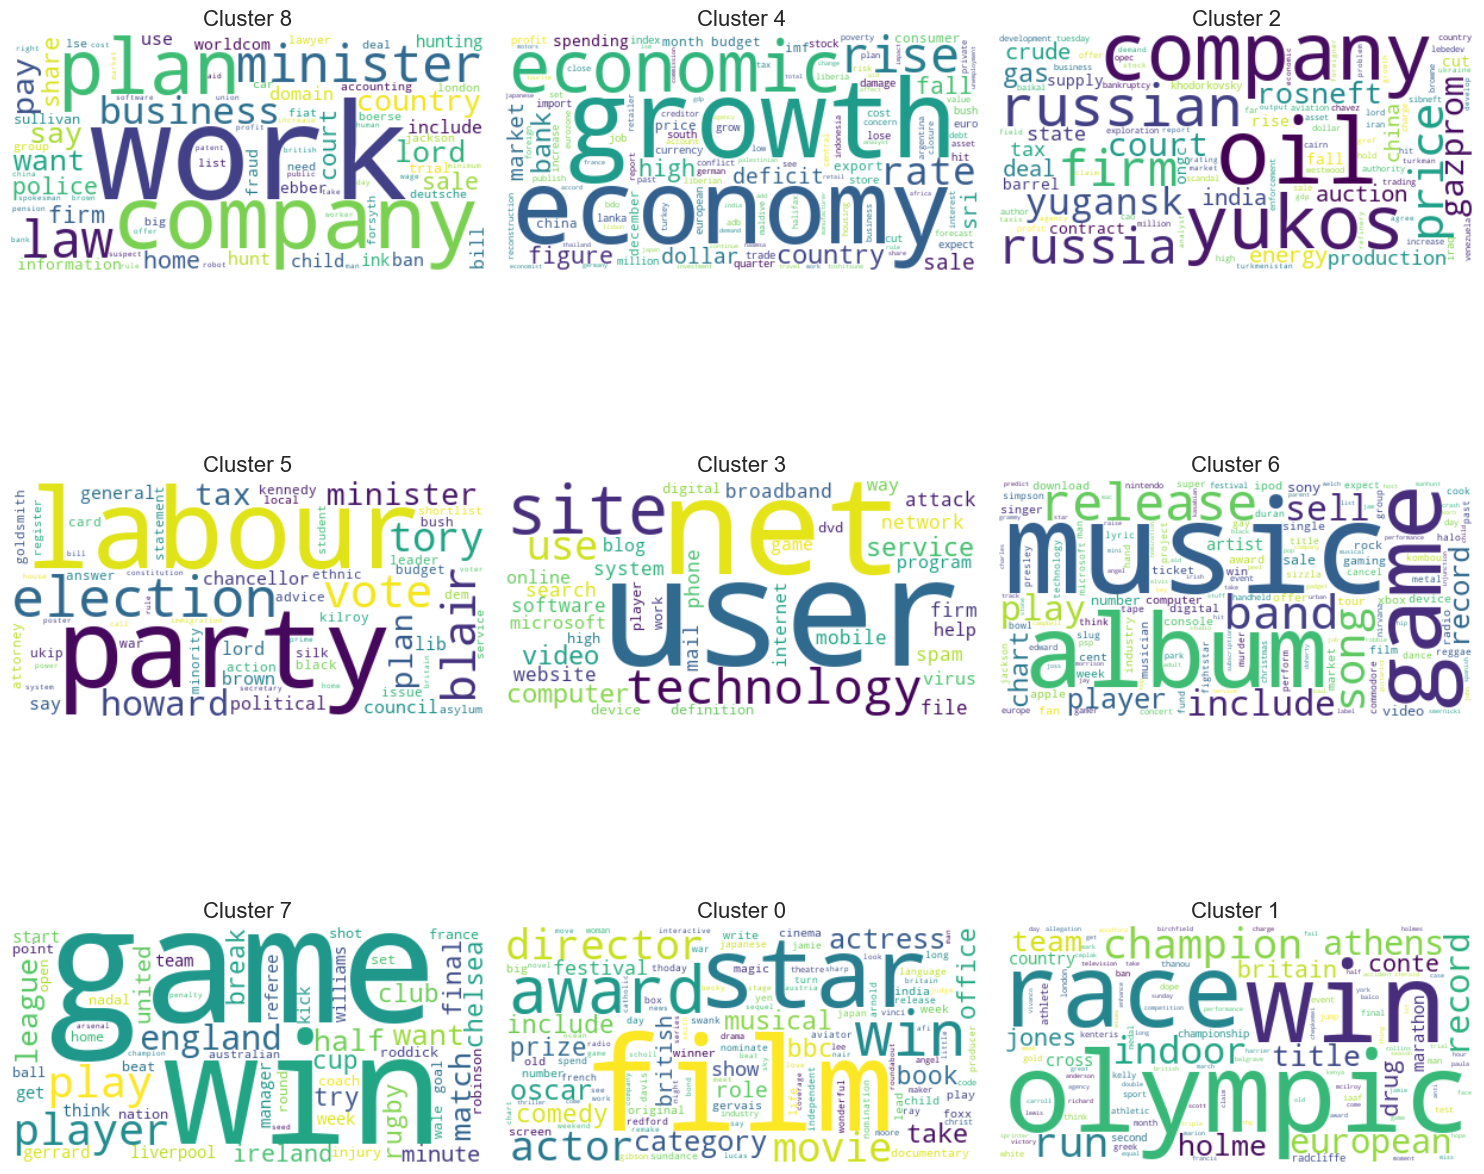

In [16]:
TOP_KWORDS_PER_TOPIC = 10

unique_clusters = df['cluster'].unique()
num_clusters = len(unique_clusters)

cols = math.ceil(math.sqrt(num_clusters))
rows = math.ceil(num_clusters / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for idx, cluster_num in enumerate(unique_clusters):
    lda_model = best_lda_models[cluster_num]
    keywords = []

    for topic_id in range(lda_model.num_topics):
        top_terms = lda_model.show_topic(topic_id, topn=TOP_KWORDS_PER_TOPIC)
        keywords.extend([term for term, _ in top_terms])

    keyword_counts = Counter(keywords)

    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(keyword_counts)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Cluster {cluster_num}', fontsize=16)
    axes[idx].axis('off')

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
